In [7]:
import matplotlib as mpl
from Datasets import * 

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
from LiteModels import DeepLite
from Datasets import *

from MMD.mmd import MMD_3_Sample_Test
import h5py as h5
from tqdm import trange
from scipy.misc import imresize
import seaborn as sns
import pandas as pd

from nuts import nuts
from nuts.emcee_nuts import NUTSSampler
from maf import experiments as ex

from KCEF.estimators.kcef import KCEF_Gaussian
from Datasets import *
from KCEF.tools import median_heuristic
from Utils import get_grid


%matplotlib inline

## Load data

In [8]:
n_hiddens = 20
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

N = 5000
seed = 12
niter = 10000
ntrain = 100
nvalid = 100
npoint = 200
patience =30
nlayer = 3

idx_i, idx_j = 0,1

ngrid = 100
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(2)
eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)

In [5]:
p = load_data("funnel",D=2,  N=5000, seed=seed)

# Training the model
If want to retrain, set `gpu_count=1` if you have a gpu

In [6]:
est = KCEF_Gaussian(graph_type = 'full', d = p.D, graph = None)
res = est.optimize_cv_score(p.data[:1000])
est.update_parameters(res)
est.fit(p.data[:1000])

In [24]:
est.logpdf_multiple(p.data[:100]).mean()

-4.0448365533671025

In [13]:
dl_model = DeepLite(p, npoint=200, nlayer=3, nneuron=20, init_log_lam=-3, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.05,
                    points_type="fixed", log_lam_weights=-6, step_size=1e-3, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=True,
                    niter=1000, ntrain=100, nvalid=100, patience=100, seed=seed,gpu_count=1, kernel_type="gaussian")
res = dl_model.fit(niter=10000, ntrain=100, nvalid=100,ntest=500, nbatch=1, patience=30)

trainining kernel:   3%|  | 326/10001 [01:05<16:52,  9.56it/s[{'test': '-2.092', 'loss': '-2.141'}]]


KeyboardInterrupt: 

# visualize some variables in the model

/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


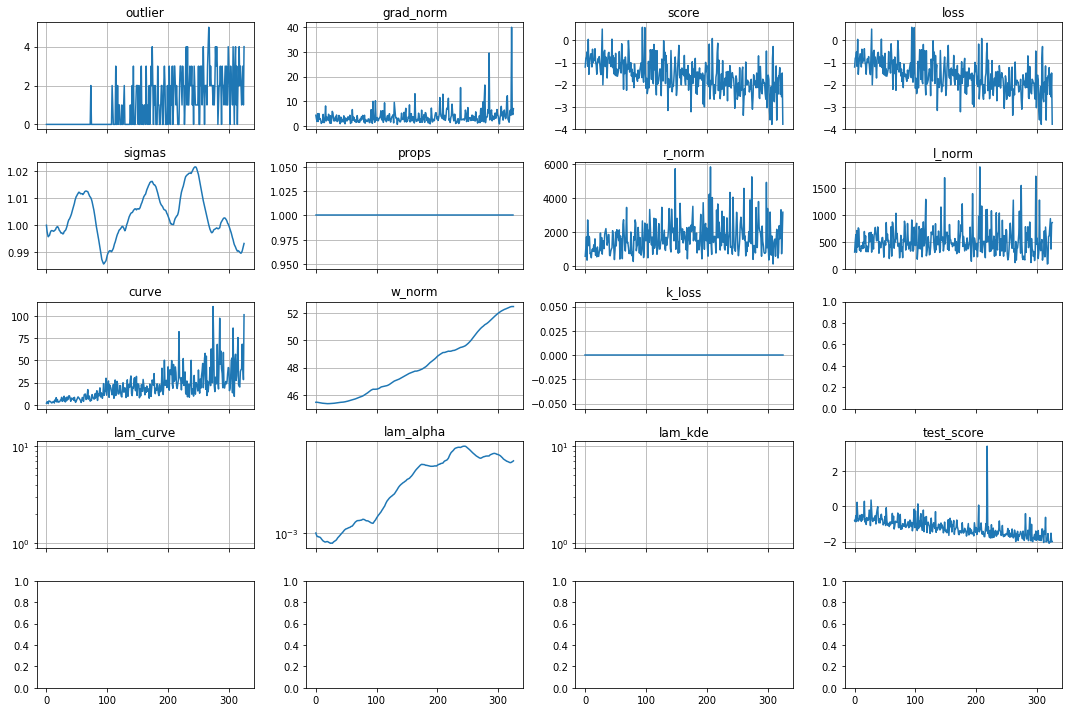

In [14]:
fig, axes = plt.subplots(5,4,figsize=(15,10), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    if k == "lam_norm":
        continue
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")
        
        
fig.tight_layout()

In [15]:
# final fit of alphas. Better do it on cpu so have to redefine the model (set True) and tell it gpu_count = 0
dl_model.set_test(True, 0) 
dl_model.fit_alpha(5000)

INFO:tensorflow:Restoring parameters from ckpts/F_D02_l3_nd20_np200_nt100_nv100_ptf_ss10_ni1000_n05_k10_m0_b1_p30_nk1_c0_s01.ckpt


In [16]:
# evaluate log likelihood, repeat to see whether reliable
for i in range(2):
    dl_model.logZ = None
    dl_model.estimate_normaliser(n=2*10**6, batch_size=10**5, std=p.test_data.std()*1.0)
    test_loglik = dl_model.estimate_data_lik(p.test_data, batch_size=p.test_data.shape[0])
    print test_loglik.mean()
dl_model_loglik = test_loglik.mean()

-3.67721944376
-3.67649395964


# Visualise density of two dimensions conditioned on others dimensions being zeros

In [17]:
def get_grid(r, i, j, cond):


    grid = np.meshgrid(r,r)

    grid = np.stack(grid,2)
    grid = grid.reshape(-1,2)
    
    num_point = len(grid)
    grid_cond = np.tile(cond[None,:], [num_point, 1])
    
    grid_cond[:,i] = grid[:,0]
    grid_cond[:,j] = grid[:,1]
    return grid_cond

In [22]:
idx_i, idx_j = 0,1

ngrid = 50
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(p.D)
epsilon = 1.5

eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


fv = dl_model.fun_multiple(eval_points)
#gv = dl_model.grad_multiple(eval_points)

#fv = p.logpdf_multiple(eval_points)
#gv = p.grad_multiple(eval_points)
#fv = kde.score_samples(eval_points)


#gv = gv.reshape(ngrid, ngrid, p.D)
gint = 5


fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
#ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.9)


ax = axes[1]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-5)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)
ax.scatter(points_val[:1000,idx_i], points_val[:1000,idx_j], 5, color="k", alpha=0.8, vmin=1, marker="x")
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
#idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
#data_in_range = p.test_data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())

KeyboardInterrupt: 

# Visualize kernel

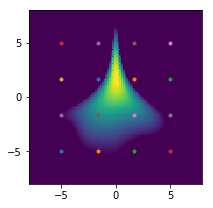

In [40]:
grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

plt.figure(figsize=(3,3))
kernel_vals = []
for ki in range(len(dl_model.ops["kernel_grams"])):
    
    kvs = dl_model.sess.run(dl_model.ops["kernel_grams"][ki], feed_dict={dl_model.test_points: grid_points, dl_model.test_data: grid_data})
    kernel_vals.append(kvs)
    for i in range(kvs.shape[0]):
        kv = kvs[i]
        plt.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+3)])
        plt.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
pcolor = plt.pcolor(grid_data_one, grid_data_one, logpdf.reshape(ngrid, ngrid), vmin=-4)
pcolor.set_edgecolor('face')
plt.xlim(grid_data_one.min(),grid_data_one.max())
plt.ylim(grid_data_one.min(),grid_data_one.max())
plt.gca().set_yticks([-5,0,5])
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
#plt.colorbar()
#plt.savefig("figs/%s.pdf"%p.name)

# Train maf and sample from it

In [15]:
n_hiddens = 20
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

#p = load_data("ring",D=2, data_args={"nring":1, "sigma":0.2}, N=5000, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)

if p.name == "Ring":
    maf_data_obj = ex.load_data("ring", D=p.D, data_args={"nring":1, "sigma":0.2}, 
                                noise_std=0, seed=seed, itanh=False, whiten=False, N=5000)
elif p.name == "Spiral":
    maf_data_obj = ex.load_data("spiral", D=p.D, data_args={"sigma":0.2, "eps":1.5}, 
                                noise_std=0, seed=seed, itanh=False, whiten=False, N=5000)
elif p.name == "Funnel":
    maf_data_obj = ex.load_data("funnel",D=2,  N=5000, seed=seed, itanh=False, whiten=True)
    
elif p.name == "Cosine":
    maf_data_obj = ex.load_data("cosine",D=2,  N=5000, seed=seed, itanh=False, whiten=True)
elif p.name == "array":
    data = np.random.rand(5000,2) * 6-3
    maf_data_obj = ex.load_data("array", data_array=data, whiten=False, itanh=False)

grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

mog_made_model = ex.train_mog_made([n_hiddens]*2, act_fun, n_comps, mode)
ex.save_model(mog_made_model, "mog_made", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_made_model = ex.load_model("mog_made", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_made_pdf = mog_made_model.eval(grid_data)
mog_made_loglik = mog_made_model.eval(p.test_data).mean()
print "mog_made %.5f" % mog_made_loglik

made_model = ex.train_made([n_hiddens]*2, act_fun, mode)
ex.save_model(made_model, "made", mode, [n_hiddens]*2, act_fun, n_comps, False)
made_model = ex.load_model("made", mode, [n_hiddens]*2, act_fun, n_comps, False)
made_pdf = made_model.eval(grid_data)
made_loglik = made_model.eval(p.test_data).mean()
print "made %.5f" % made_loglik


nvp_model =ex.train_realnvp([n_hiddens]*2, 'tanh', 'relu', n_layers)
ex.save_model(nvp_model, "nvp", mode, [n_hiddens]*2, act_fun, n_comps, False)
nvp_model = ex.load_model("nvp", mode, [n_hiddens]*2, act_fun, n_comps, False)
nvp_pdf = nvp_model.eval(grid_data)
nvp_loglik = nvp_model.eval(p.test_data).mean()
print "nvp %.5f" % nvp_loglik


maf_model = ex.train_maf([n_hiddens]*2, act_fun, n_layers, mode)
ex.save_model(maf_model, "maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
maf_model = ex.load_model("maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
maf_pdf = maf_model.eval(grid_data)
maf_loglik = maf_model.eval(p.test_data).mean()
print "maf %.5f" % maf_loglik

mog_maf_model = ex.train_maf_on_made([n_hiddens]*2, act_fun, n_layers, n_comps, mode)
ex.save_model(mog_maf_model, "mog_maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_maf_model = ex.load_model("mog_maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_maf_pdf = mog_maf_model.eval(grid_data)
mog_maf_loglik = mog_maf_model.eval(p.test_data).mean()
print "mog_maf %.5f" % mog_maf_loglik

mog_made -3.64516
made -3.92436
nvp -3.73140


maf/ml/models/mafs.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  input_order = input_order if input_order == 'random' else made.input_order[::-1]


maf -3.68914


AttributeError: 'RealToy' object has no attribute 'otest_data'

In [16]:
mog_maf_loglik = mog_maf_model.eval(p.test_data).mean()
print "mog_maf %.5f" % mog_maf_loglik

mog_maf -3.67051


In [12]:
np.savez("figs/%s_data"%p.name, 
         kernel_vals=kernel_vals, logpdf=logpdf, grid_points=grid_points, dl_model_loglik=dl_model_loglik,
        made_pdf=made_pdf, made_mog_pdf=mog_made_pdf, nvp_pdf=nvp_pdf, maf_pdf=maf_pdf, maf_mog_pdf=mog_maf_pdf,
        made_loglik=made_loglik, made_mog_loglik=mog_made_loglik, nvp_loglik=nvp_loglik, maf_loglik=maf_loglik, maf_mog_loglik=mog_maf_loglik,)

In [12]:
np.log(norm.pdf(2)**2)

-5.8378770664093453

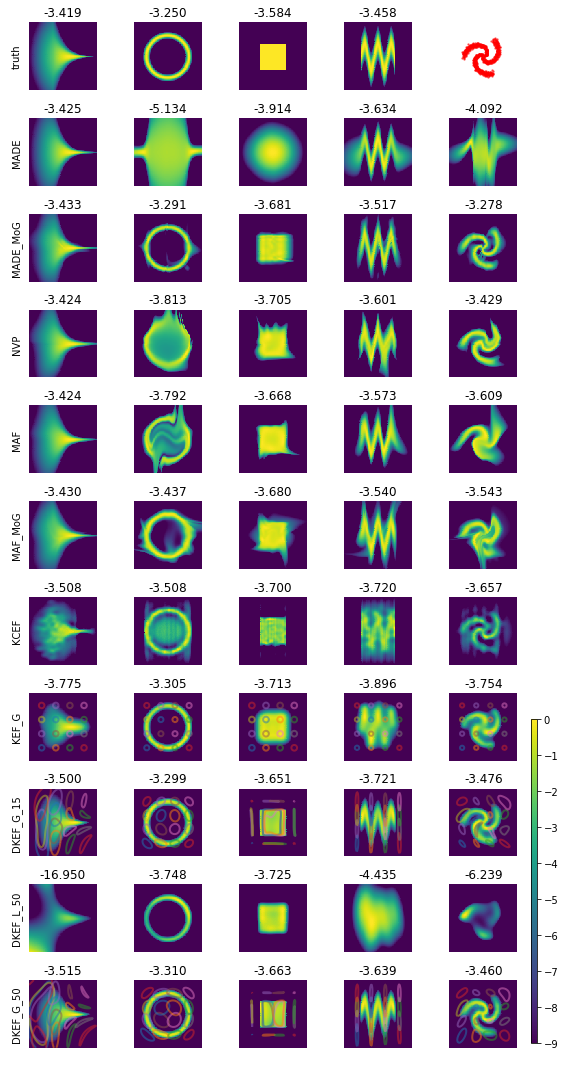

In [10]:
fig, axes = plt.subplots(11, 5, figsize=(8,15))

others_list =["MADE", "MADE_MoG", "NVP", "MAF", "MAF_MoG"]


idx_i, idx_j=0,1
grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(2))

grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(2))

def plot_logpdf(ax, pdf):
    pdf -= pdf.max()
    ngrid = int(np.sqrt(pdf.shape[0]))
    pcolor = ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid), vmin=-9)
    pcolor.set_edgecolor('face')
    ax.set_xlim(grid_data_one.min(),grid_data_one.max())
    ax.set_ylim(grid_data_one.min(),grid_data_one.max())
    ax.set_yticks([-5,0,5])
    ax.set_aspect("equal", "box")
    ax.set_axis_off()
    return pcolor


model_name_properties = dict(rotation=90,va="center", ha="right")

for di, dname in enumerate(["Funnel","Ring","Uniform", "Cosine", "Spiral"]):
#for di, dname in enumerate(["Funnel"]):

    
    ax = axes[0, di]
    this_p = load_data(dname, D=2,N=N, seed=seed)
    
    if this_p.dist.has_grad:
        
        real_pdf = this_p.logpdf_multiple(eval_points)
        plot_logpdf(ax, real_pdf)
        real_loglik = this_p.logpdf_multiple(this_p.test_data).mean()
        if di == 0:
            ax.text(-0.1,0.5,"truth", transform=ax.transAxes,  **model_name_properties)
        ax.set_title("%.3f" % real_loglik)
        #ax.scatter(p.test_data[:,0], p.test_data[:,1], 2,"r", alpha=0.1)
    else:
        s = this_p.sample(1000)
        ax.scatter(s[:,0], s[:,1],2,"r", alpha=0.5)
        ax.set_xlim(grid_data_one.min(),grid_data_one.max())
        ax.set_ylim(grid_data_one.min(),grid_data_one.max())
        ax.set_yticks([-5,0,5])
        ax.set_aspect("equal", "box")
        ax.set_axis_off()
        
    saved_pdf = np.load("figs/%s_data.npz" % this_p.name)
    for mi, mname in enumerate(others_list):
        ax = axes[mi+1, di]
        pdf = saved_pdf[mname.lower()+"_pdf"]
        plot_logpdf(ax, pdf)
        loglik = saved_pdf[mname.lower()+"_loglik"]
        
        if di == 0:
            ax.text(-0.1,0.5, mname,  transform=ax.transAxes, **model_name_properties)
        ax.set_title("%.3f"%loglik)
        
    saved_pdf = np.load("figs/kcef_%s_data.npz" % this_p.name)
    ax = axes[6, di]
    pdf = saved_pdf["kcef_logpdf"]
    plot_logpdf(ax, pdf)
    kcef_loglik = saved_pdf["kcef_loglik"]
    
    saved_pdf = np.load("figs/%s_data.npz" % this_p.name)

    if di == 0:
        ax.text(-0.1,0.5, "KCEF", transform=ax.transAxes, **model_name_properties)
    ax.set_title("%.3f"%kcef_loglik)
    
    
    lite_names = [ "sl_model", "dl_model","ll_model", "hl_model"]
    lite_display_names = [ "KEF_G", "DKEF_G_15","DKEF_L_50", "DKEF_G_50"]
    for li, ln in enumerate(lite_names):
        ax = axes[ 7+li, di]
        
        if ln != "ll_model":
            kernel_vals = saved_pdf[ln+"_kernel_vals"]
            grid_points = saved_pdf["grid_points"]
            kvs = kernel_vals
            for i in range(kvs.shape[0]):
                kv = kvs[i]
                ax.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[2], alpha=.5)
                #ax.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9), alpha=0.5)
                
        pdf = saved_pdf[ln+"_logpdf"]
        im = plot_logpdf(ax, pdf)
        model_loglik = saved_pdf[ln+"_loglik"]
        if di == 0:
            ax.text(-0.1,0.5, lite_display_names[li],  transform=ax.transAxes, **model_name_properties)
        ax.set_title("%.3f"%model_loglik)

plt.tight_layout(h_pad=-0.5, w_pad=-0.1)
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.94, 0.03, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax)
#plt.colorbar()
fig.savefig("figs/toys.png", dpi=200)

In [48]:
fig.savefig("figs/toys.jpg")